In [1]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# Links: 
#   - VNIR LUCAS: "1OnwGgDqvjnDYEik14h_lSi83M4AwzYBt"
#   - VNIR KSSL: "17ZNSqsQi6PUeOLnUozq-C6Pj22dItm_Y"
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [2]:
#!pip install spanda

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

from fastai.vision.all import *
from fastai.data.all import *

from torch.nn import init

import timm

from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, AnalytesTfm,
                                    SNVTfm, AvgTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings('ignore')

## Configs

In [3]:
root_dir = Path('../../_data/') if device != 'cuda' else Path('.')

## Utilities

In [4]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [5]:
def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return L(paths)

In [6]:
def get_dls(paths, analytes=['725'], bs=32, seed=42):
    get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
    get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

    dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=analytes)),
                       get_x=get_spectra,
                       get_y=get_target,
                       splitter=RandomSplitter(valid_pct=0.2, seed=seed),
                       item_tfms=[AvgTfm()],
                       batch_tfms=[SNVTfm(),
                                   LogTfm])
    return dblock.dataloaders(paths, bs=bs, num_workers=6)

In [7]:
current_date = lambda: datetime.now().date().isoformat()

## Data loading

In [8]:
analytes = ['725'] # Kex

In [9]:
paths_kssl = get_paths(root_dir/'kssl-vnir', analytes=analytes)

100%|██████████| 20949/20949 [00:17<00:00, 1231.22it/s]


In [10]:
paths_lucas = get_paths(root_dir/'lucas-vnir', analytes=analytes)

100%|██████████| 21782/21782 [00:17<00:00, 1262.45it/s]


In [12]:
paths_all = paths_kssl + paths_lucas; paths_all

(#42728) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

## Train & evaluate

### Train KSSL

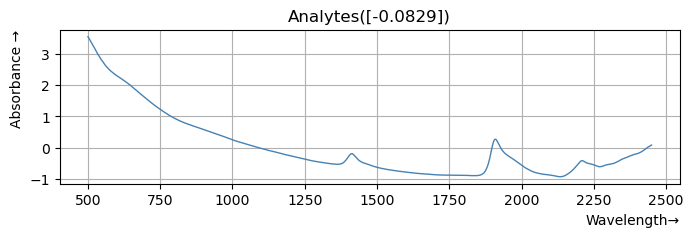

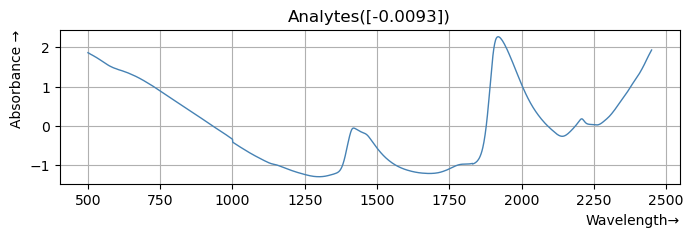

In [13]:
dls = get_dls(paths_kssl, bs=64)
dls.show_batch(max_n=2)

In [17]:
dls.train.one_batch()[0].std()

Spectra(0.9997)

In [20]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)

In [27]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): 
        init.kaiming_normal_(m.weight)

In [28]:
model.apply(init_weights);

In [ ]:

layers = [m for m in flatten_model(model) if has_params(m)]
stats = ActivationStats(with_hist=True, modules=layers, every=50, cpu=False)

learn = Learner(dls, model, 
                loss_func=MSELossFlat(), 
                metrics=R2Score(), 
                cbs=[stats])

In [ ]:
learn.lr_find(m)

KeyboardInterrupt: 

In [68]:
# params
ds_name = 'kssl'
lr = 2e-3
epochs = 20

In [69]:
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,r2_score,time
0,0.201268,0.196818,0.176528,00:32
1,0.199144,0.218594,0.085421,00:32
2,0.196609,0.244667,-0.023669,00:32
3,0.182719,0.191235,0.199886,00:32
4,0.177733,0.396463,-0.658770,00:32
5,0.147965,0.399623,-0.671992,00:32
6,0.140279,0.285504,-0.194527,00:32
7,0.119447,0.124104,0.480760,00:32
8,0.103841,0.123736,0.482297,00:31
9,0.100958,0.157117,0.342634,00:31


#### Debug weights distribution
- https://forums.fast.ai/t/interpreting-activationstats-color-dim-graphs-and-fixing-bad-layers/64742

In [70]:
def plot_stats(activation_stats, idx, figsize=(10,5), ax=None):
    res = activation_stats.stats.itemgot(idx).itemgot('hist')
    res = torch.stack(tuple(res)).t().float().log1p().to('cpu')
    
    if ax is None: ax = subplots(figsize=figsize)[1][0]
    ax.imshow(res, origin='lower')
    ax.axis('off');

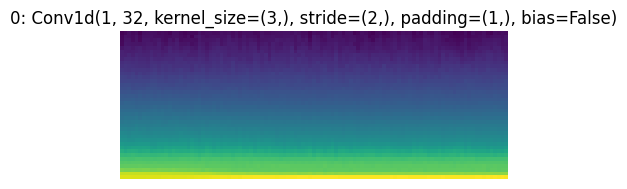

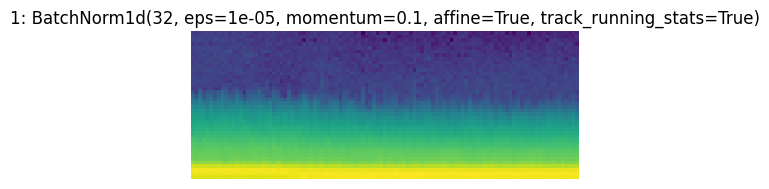

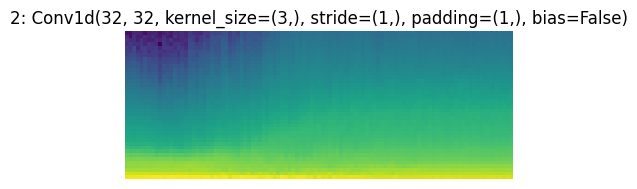

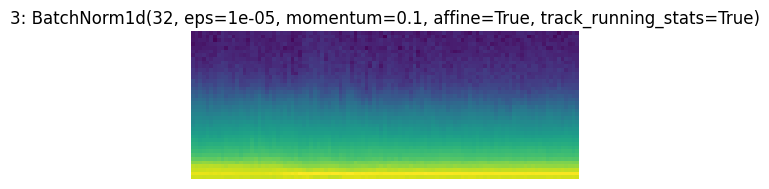

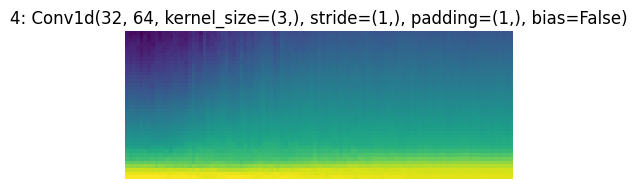

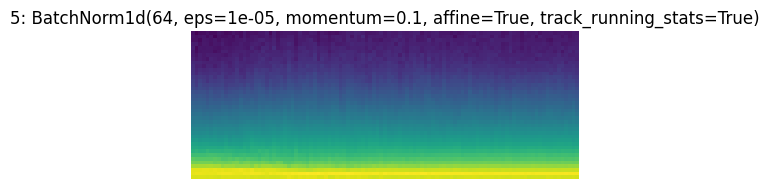

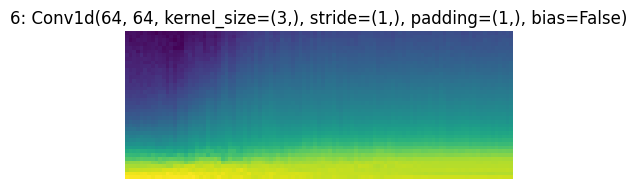

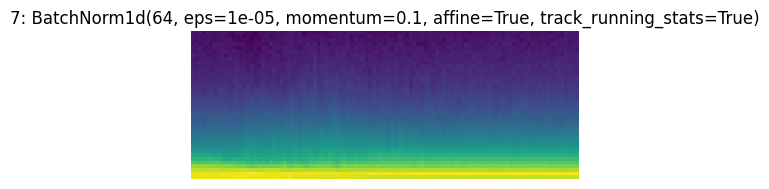

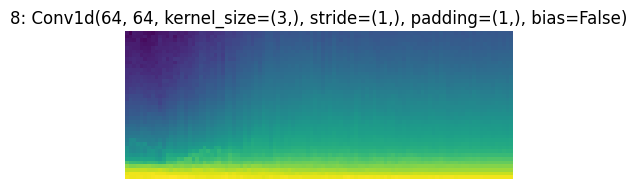

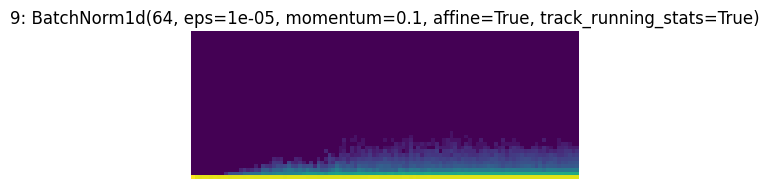

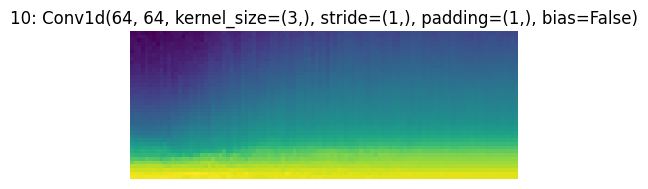

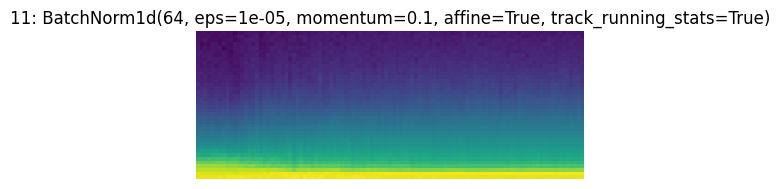

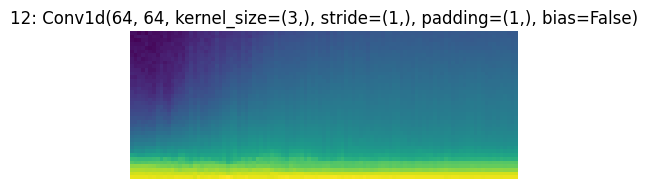

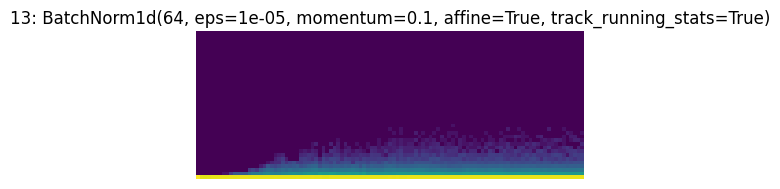

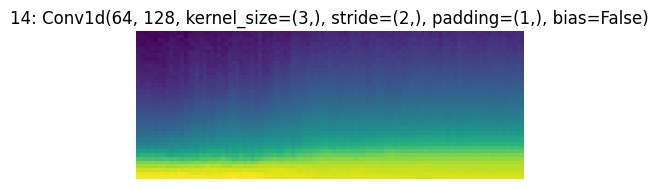

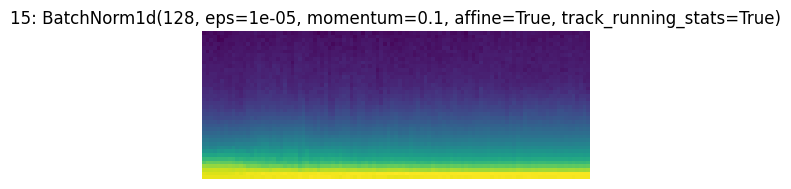

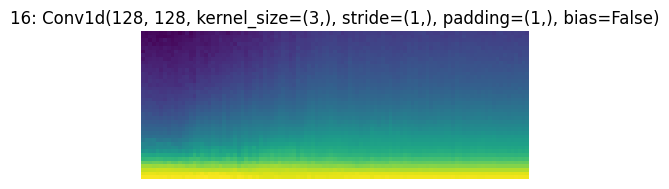

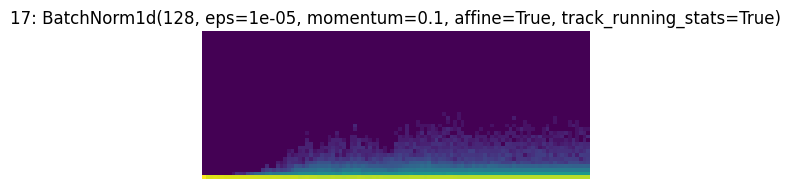

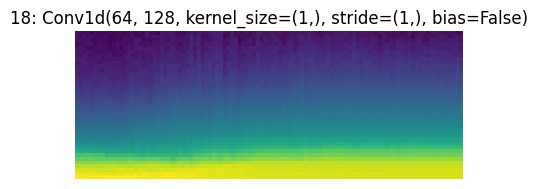

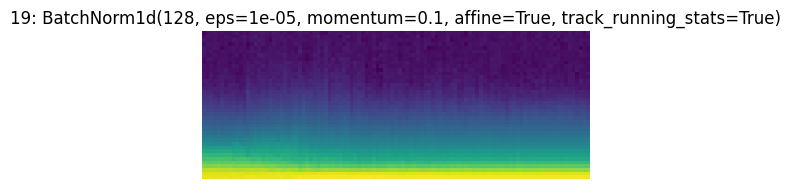

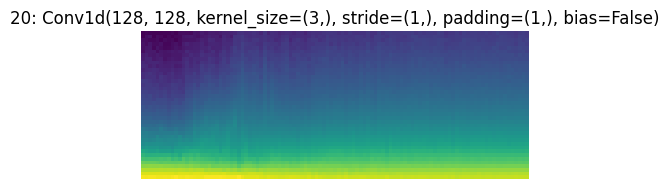

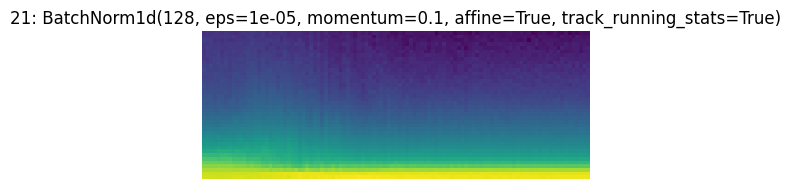

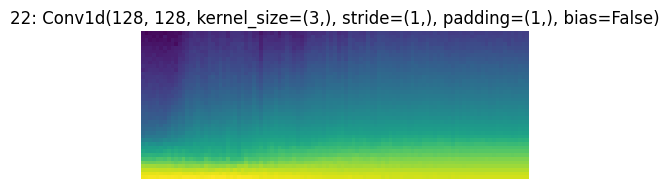

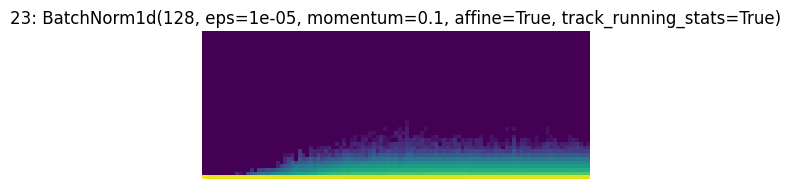

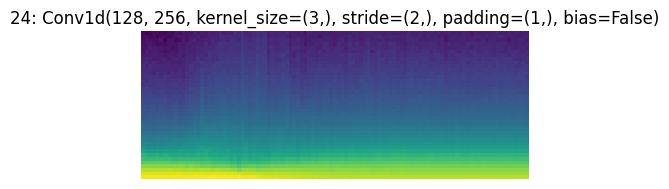

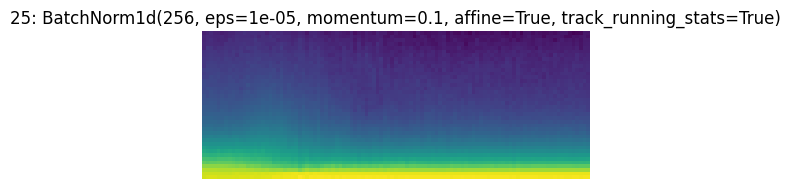

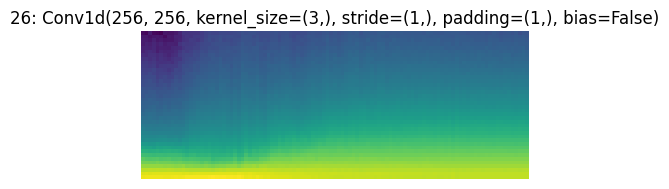

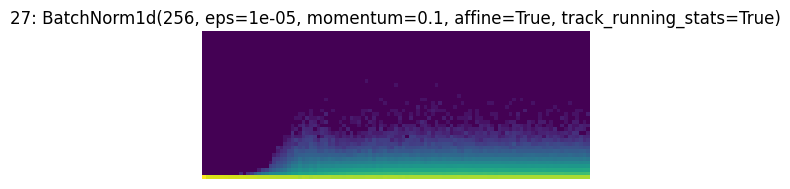

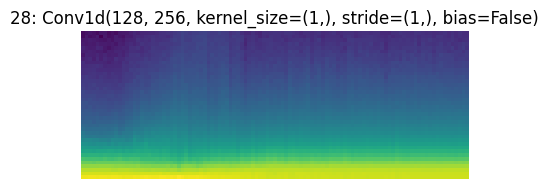

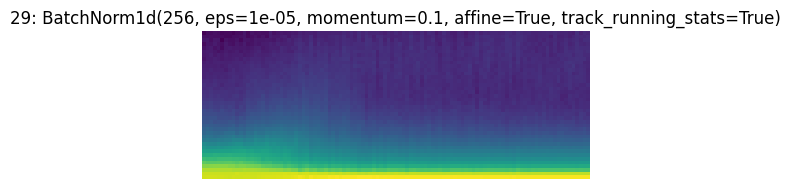

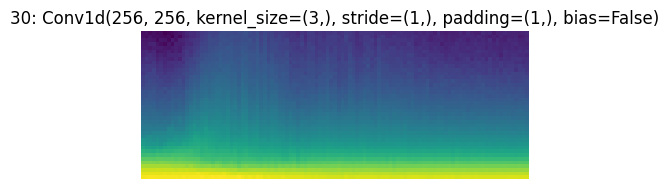

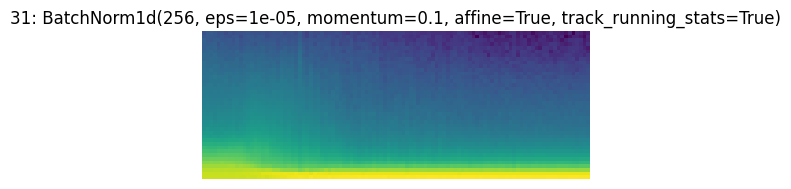

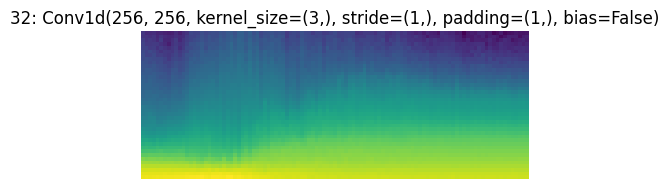

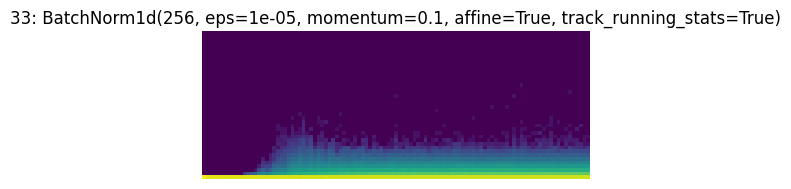

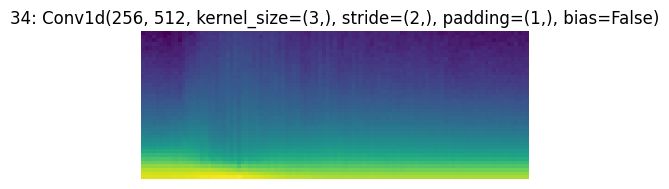

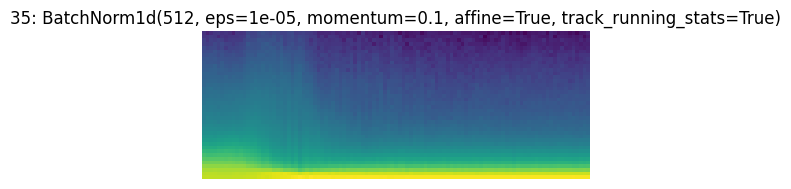

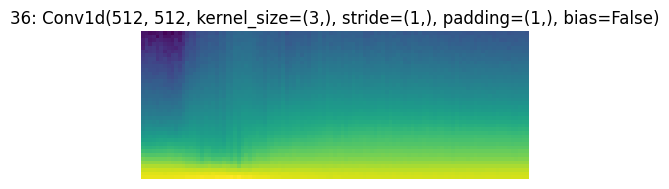

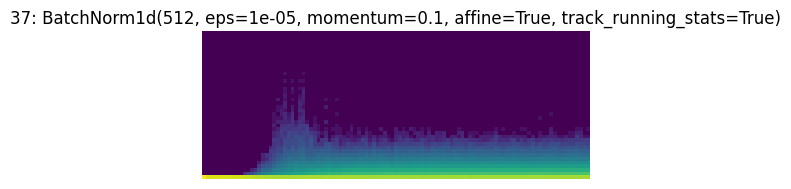

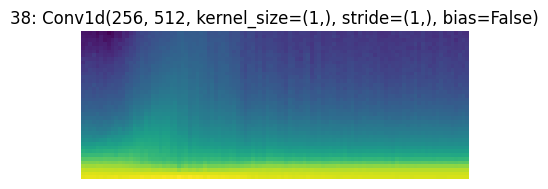

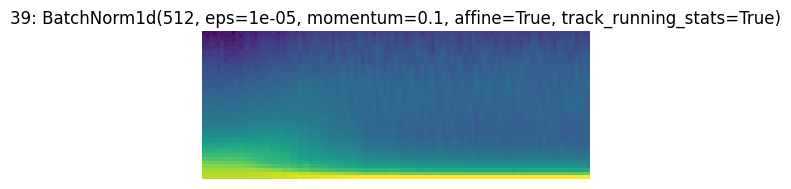

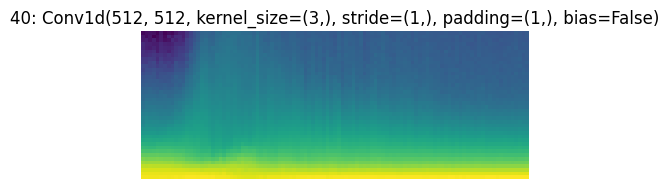

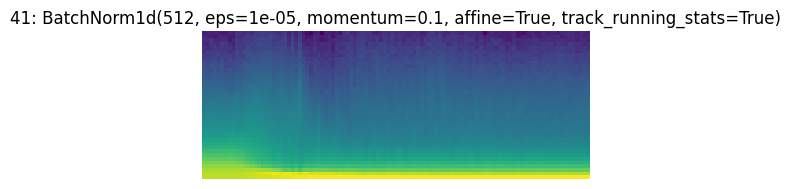

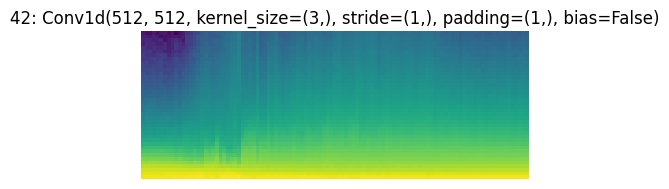

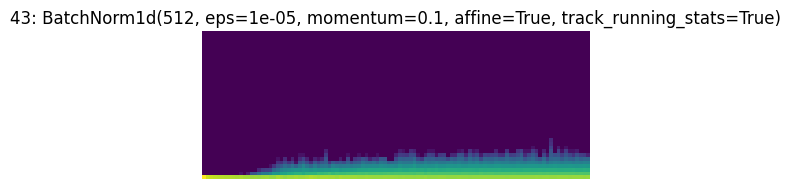

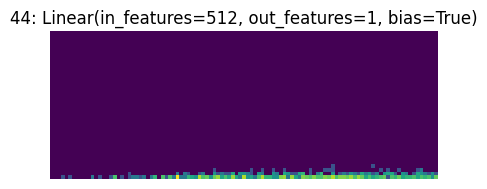

In [71]:
for i, layer in enumerate(layers):
    fig, ax = plt.subplots(figsize=(5, 10))
    ax.set_title(f'{i}: {layer}')
    plot_stats(learn.activation_stats, i, ax=ax)

#### Eval on KSSL

In [74]:
# r2: 0.735 on 40 epochs, lr: 2e-3, bs:64
preds_kssl, targs_kssl = learn.get_preds(ds_idx=1)
r2_score(targs_kssl, preds_kssl)

0.6953573880025067

In [75]:
model_name = f'xresnet18-kex-nirs-{ds_name}-{epochs}-epochs-lr-{lr:.1e}-r2-{r2_score(targs_kssl, preds_kssl):.2}-{current_date()}'

In [76]:
learn.save(model_name)

Path('models/xresnet18-kex-nirs-kssl-20-epochs-lr-2.0e-03-r2-0.7-2023-06-13.pth')

In [78]:
dls_lucas = get_dls(paths_lucas)

In [ ]:
preds_lucas, targs_lucas = learn.get_preds(dl=dls_lucas.valid)

#### Eval on LUCAS

In [ ]:
# Eval on 
r2_score(targs_lucas, preds_lucas)

-0.2357146436679538

#### Finetune LUCAS on KSSL

In [ ]:
dls_lucas = get_dls(paths_lucas[:100])

In [ ]:
# Pre-trained model (KSSL)
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
layers = [m for m in flatten_model(model) if has_params(m)]

stats = ActivationStats(with_hist=True, modules=layers)
learn = Learner(dls_lucas, model, 
                loss_func=MSELossFlat(), 
                metrics=R2Score(), 
                cbs=[stats])

In [ ]:
weights_paths = root_dir/ 'models/xresnet18-kex-nirs-kssl-20-epochs-lr-2.0e-03-r2-0.69-2023-06-12.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device(device)) 
model.load_state_dict(xresnet_dict['model'])

<All keys matched successfully>

In [ ]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.124938,0.360897,-3.153063,00:06
1,0.132987,0.339052,-2.901673,00:06
2,0.122835,0.189272,-1.178064,00:06
3,0.124629,0.153498,-0.766399,00:06
4,0.121006,0.149922,-0.725241,00:06
5,0.115319,0.121862,-0.402340,00:06
6,0.114376,0.111439,-0.282393,00:06
7,0.111704,0.106091,-0.220851,00:06
8,0.108847,0.104015,-0.196969,00:06
9,0.107374,0.102611,-0.180810,00:06


In [ ]:
learn.summary()

XResNet (Input shape: 32 x 1 x 1951)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 976       
Conv1d                                    96         True      
BatchNorm1d                               64         True      
ReLU                                                           
Conv1d                                    3072       True      
BatchNorm1d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 976       
Conv1d                                    6144       True      
BatchNorm1d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 488       
MaxPool1d                                  

In [ ]:
for layer in flatten_model(learn):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.BatchNorm1d):
        for param in layer.parameters():
            param.requires_grad = True
    else:
        for param in layer.parameters():
            param.requires_grad = False      

SuggestedLRs(valley=0.0010000000474974513)

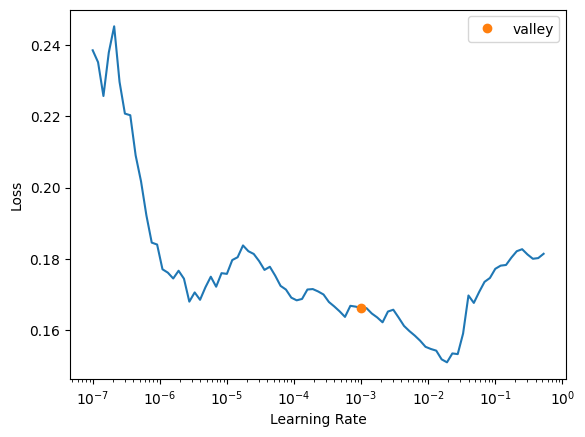

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 1e-3)
#learn.fit_one_cycle(20, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,r2_score,time
0,0.113442,0.110231,0.249803,00:29
1,0.095094,0.093880,0.361085,00:32
2,0.089150,0.082234,0.440345,00:32
3,0.086316,0.081131,0.447853,00:31
4,0.082815,0.078304,0.467093,00:32
5,0.083117,0.074273,0.494525,00:33
6,0.084979,0.073475,0.499951,00:32
7,0.084978,0.077548,0.472235,00:31
8,0.076220,0.072954,0.503497,00:34
9,0.075383,0.073276,0.501307,00:34


In [ ]:
preds_lucas, targs_lucas = learn.get_preds()

In [ ]:
# r2: 0.62 when finetuned over 20 epochs and lr=slice(1e-5,1e-3), bs=32
# r2: 0.54 when finetuned over 20 epochs and lr=1e-3, bs=32 and only batchnorm and linear trainable

r2_score(targs_lucas, preds_lucas)

0.626576297559692